<a href="https://colab.research.google.com/github/marcomag416/MLDL/blob/main/Copy_of_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 4: Transfer Learning and Visualizations


> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.



## Step 1: Install missing dependencies and import libraries

In [ ]:
# Install missing dependencies
!pip install -q torchinfo torchmetrics wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from torchinfo import summary

import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Step 2: plot a confusion matrix of the predictions on the test set

### Get data

In [ ]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
!mkdir -p data
!unzip -n pizza_steak_sushi.zip -d data/pizza_steak_sushi

--2024-04-22 14:08:02--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2024-04-22 14:08:02--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.06s   

2024-04-22 14:08:03 (247 MB/s) - ‘pizza_steak

### Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names

data_path = "data/pizza_steak_sushi"
train_dset = ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset = ImageFolder(f"{data_path}/test", transform=simple_transform)
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")


train_dataloader = DataLoader(train_dset, batch_size=32, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_dset, batch_size=32, num_workers=2)

# train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'sushi', 'steak']


### Get and prepare a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [ ]:
def train(model, optimizer, dataloader, loss_fn):
    model.train()
    for inputs, targets in dataloader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    return

def test(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_loss = test_loss / len(dataloader)
    test_accuracy = 100. * correct / total
    return test_accuracy


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for _ in tqdm(range(1000)):
    train(model_0, optimizer, train_dataloader, loss_fn)
    test_acc = test(model_0, test_dataloader, loss_fn)
    print(f"Test accuracy: {test_acc}")  # You should get values around 90% accuracy on the test set


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 92.0
Test accuracy: 94.66666666666667
Test accuracy: 94.66666666666667
Test accuracy: 90.66666666666667
Test accuracy: 94.66666666666667
Test accuracy: 94.66666666666667
Test accuracy: 92.0
Test accuracy: 93.33333333333333
Test accuracy: 96.0
Test accuracy: 88.0
Test accuracy: 93.33333333333333
Test accuracy: 90.66666666666667
Test accuracy: 89.33333333333333
Test accuracy: 92.0
Test accuracy: 92.0
Test accuracy: 90.66666666666667
Test accuracy: 93.33333333333333
Test accuracy: 92.0
Test accuracy: 90.66666666666667
Test accuracy: 90.66666666666667
Test accuracy: 92.0
Test accuracy: 93.33333333333333
Test accuracy: 89.33333333333333
Test accuracy: 96.0
Test accuracy: 92.0
Test accuracy: 94.66666666666667
Test accuracy: 96.0
Test accuracy: 96.0
Test accuracy: 93.33333333333333
Test accuracy: 92.0
Test accuracy: 92.0
Test accuracy: 93.33333333333333
Test accuracy: 96.0
Test accuracy: 93.33333333333333
Test accuracy: 90.66666666666667
Test accuracy: 93.33333333333333
Test ac

### Make a confusion matrix with the test preds and the truth labels

HINT: Look at the torchmetrics.functional.classification.multiclass_confusion_matrix from the torchmetrics library

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

preds_all = []
targets_all = []
inputs_all = []

model_0.eval()
with torch.no_grad():
  for inputs, targets in test_dataloader:
    inputs_all.append(inputs.to(device))
    preds_all.append(model_0(inputs.to(device)))
    targets_all.append(targets.to(device))

preds_all = torch.cat(preds_all, dim=0)
targets_all = torch.cat(targets_all, dim=0)
inputs_all = torch.cat(inputs_all, dim=0)
preds_all = nn.Softmax(dim=1)(preds_all)
metric = MulticlassConfusionMatrix(num_classes=3).to(device)
metric(preds_all, targets_all)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([[21,  1,  3],
        [ 0, 17,  2],
        [ 0,  2, 29]], device='cuda:0')

## Step 3: Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

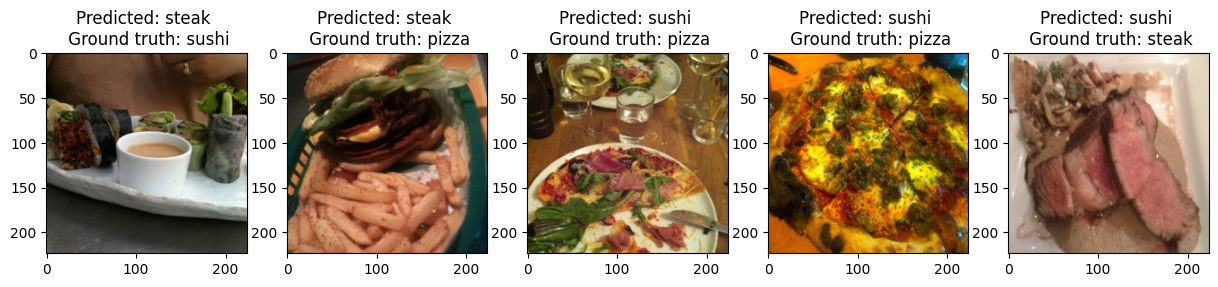

    label  prediction  pred_prob
70      2           1   0.976171
12      0           1   0.918729
24      0           2   0.773440
13      0           2   0.716363
34      1           2   0.704193


In [ ]:
import pandas as pd
pred_prob, pred_labels = preds_all.max(dim=1)

class_names= ['pizza', 'steak', 'sushi']

def denormalize(image):
    image = image.to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

df = pd.DataFrame({'label': targets_all.cpu(),
              'prediction': pred_labels.cpu(),
              'pred_prob': pred_prob.cpu()})

df = df[df['prediction'] != df['label']]
df.sort_values('pred_prob', axis="index", inplace=True, ascending=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

for idx, sample_idx in enumerate(df.head(5).index):
  sample = inputs_all[sample_idx].squeeze()
  axes[idx].imshow(denormalize(sample), cmap="Greys")
  axes[idx].set_title(f"Predicted: {class_names[df['prediction'].loc[sample_idx]]} \n Ground truth: {class_names[df['label'].loc[sample_idx]]}")

plt.show()

print(df.head(5))

## Step 4: Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
!mkdir -p data
!unzip pizza_steak_sushi_20_percent.zip -d data/pizza_steak_sushi_20_percent

--2024-04-22 16:03:51--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip [following]
--2024-04-22 16:03:51--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31491084 (30M) [application/zip]
Saving to: ‘pizza_steak_sushi_20_percent.zip’

pizza_steak_sushi_2 100%[===================>]  30.03M  --.-KB/s    in 0.1s    

2

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names

data_path = "data/pizza_steak_sushi_20_percent"
train_dset_20p= ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset_20p = ImageFolder(f"{data_path}/test", transform=simple_transform)
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")


train_dataloader_20p = DataLoader(train_dset_20p, batch_size=32, num_workers=2, shuffle=True)
test_dataloader_20p = DataLoader(test_dset_20p, batch_size=32, num_workers=2)

# train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'sushi', 'steak']


### Get a pretrained model

In [ ]:
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train a model with 20% of the data

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for _ in tqdm(range(1000)):
    train(model_1, optimizer, train_dataloader_20p, loss_fn)
    test_acc = test(model_1, test_dataloader_20p, loss_fn)
    print(f"Test accuracy: {test_acc}")


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 90.0
Test accuracy: 90.0
Test accuracy: 88.66666666666667
Test accuracy: 88.66666666666667
Test accuracy: 90.66666666666667
Test accuracy: 90.0
Test accuracy: 92.0
Test accuracy: 90.0
Test accuracy: 90.66666666666667
Test accuracy: 93.33333333333333
Test accuracy: 94.0
Test accuracy: 91.33333333333333
Test accuracy: 92.66666666666667
Test accuracy: 92.0
Test accuracy: 90.0
Test accuracy: 92.66666666666667
Test accuracy: 91.33333333333333
Test accuracy: 92.66666666666667
Test accuracy: 93.33333333333333
Test accuracy: 92.0
Test accuracy: 92.66666666666667
Test accuracy: 94.0
Test accuracy: 92.66666666666667
Test accuracy: 93.33333333333333
Test accuracy: 93.33333333333333
Test accuracy: 92.66666666666667
Test accuracy: 92.66666666666667
Test accuracy: 93.33333333333333
Test accuracy: 94.0
Test accuracy: 93.33333333333333
Test accuracy: 94.0
Test accuracy: 92.0
Test accuracy: 92.0
Test accuracy: 90.0
Test accuracy: 92.0
Test accuracy: 93.33333333333333
Test accuracy: 93.33

## Step 5: Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# Create training and testing DataLoader's as well as get a list of class names

data_path = "data/pizza_steak_sushi_20_percent"
train_dset_20p= ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset_20p = ImageFolder(f"{data_path}/test", transform=simple_transform)
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")


train_dataloader_20p = DataLoader(train_dset_20p, batch_size=32, num_workers=2, shuffle=True)
test_dataloader_20p = DataLoader(test_dset_20p, batch_size=32, num_workers=2)

# train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'sushi', 'steak']


In [ ]:
model_2 = torchvision.models.efficientnet_b7(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=model_2.classifier[-1].in_features,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for _ in tqdm(range(20)):
    train(model_2, optimizer, train_dataloader_20p, loss_fn)
    test_acc = test(model_2, test_dataloader_20p, loss_fn)
    print(f"Test accuracy: {test_acc}")


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Test accuracy: 94.66666666666667
Test accuracy: 95.33333333333333
Test accuracy: 98.0
Test accuracy: 97.33333333333333
Test accuracy: 97.33333333333333
Test accuracy: 99.33333333333333
Test accuracy: 99.33333333333333
Test accuracy: 98.0
Test accuracy: 98.66666666666667
Test accuracy: 98.66666666666667
Test accuracy: 98.66666666666667
Test accuracy: 99.33333333333333
Test accuracy: 99.33333333333333
Test accuracy: 98.66666666666667
Test accuracy: 99.33333333333333
Test accuracy: 98.66666666666667
Test accuracy: 98.66666666666667
Test accuracy: 99.33333333333333
Test accuracy: 99.33333333333333
Test accuracy: 99.33333333333333
[INFO] Total training time: 935.449 seconds
